In [1]:
import pandas as pd
import numpy as np
from src import LogisticRegression, DPLogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression as LogisticRegressionSK
from sklearn.linear_model import LogisticRegressionCV as LogisticRegressionCVSK
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm_notebook as tqdm
import pickle

### Read in data
- Using publicly available Wisconsin breast cancer data
    - Small dataset but with good predictors

In [2]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X, y = load_breast_cancer(return_X_y = True)

In [3]:
# split data into train and test
X_train , X_test , y_train , y_test = train_test_split (X, y , test_size=0.2, random_state = 919)
# normalize data
mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

### sklearn model

In [4]:
lr = LogisticRegressionSK(n_jobs = -1)
lr.fit(X_train, y_train)
lbfgs_test_acc = accuracy_score(y_test, lr.predict(X_test)) 

### Model

In [5]:
# model hyperparameters
learning_rate = 0.1
n_iter = 50000
batch_size = 32
clipping_param = 1
tol = 0.001

In [6]:
np_model = LogisticRegression(lr=learning_rate, num_iter=n_iter, verbose=False, tol = tol)
np_model.fit(X_train, y_train, batch_size=batch_size, sample_with_replacement=True, 
             gradient_clipping=True, clipping_param = clipping_param)

np_preds_train = np_model.predict(X_train, threshold = 0.5)
np_train_acc = accuracy_score(y_train, np_preds_train)
# get accuracy
np_preds_test = np_model.predict(X_test, threshold = 0.5)
np_test_acc = accuracy_score(y_test, np_preds_test)

 12%|█▏        | 5888/50000 [00:10<01:05, 670.97it/s]

In [7]:
print('Non-Private Logistic Regression\nTrain Accuracy: {}\nTest Accuracy: {}'.format(
    np.round(np_train_acc,5), np.round(np_test_acc,5)))

Non-Private Logistic Regression
Train Accuracy: 0.96703
Test Accuracy: 0.97368


### Private Logistic Regression

In [8]:
sigma=2
delta=1e-6
clipping_param = 1
model = DPLogisticRegression(lr=learning_rate, num_iter=n_iter, verbose=False, fit_intercept = True, 
                            clipping_param=clipping_param, sigma=sigma, delta=delta, tol = tol)

model.fit(X_train, y_train, batch_size=batch_size, repeat_data = True, sample_with_replacement = True)


  5%|▌         | 2608/50000 [00:05<01:09, 683.54it/s]


In [9]:
dp_train_preds = model.predict(X_train, threshold = 0.5) # get model predictions TRAIN
dp_train_acc = accuracy_score(y_train, dp_train_preds) # get accuracy TRAIN
dp_test_preds = model.predict(X_test, threshold = 0.5) # get model predictions TEST
dp_test_acc = accuracy_score(y_test, dp_test_preds) # get accuracy TEST

In [10]:
print('DP Logistic regression\nEpsilon = {}  when delta = {}'.format(round(model.epsilon,4), delta))

DP Logistic regression
Epsilon = 0.4891  when delta = 1e-06


### Model Comparison

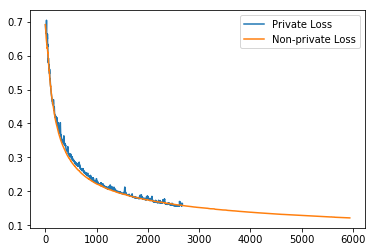

In [11]:
plt.plot(model.loss_by_epoch, label = 'Private Loss')
plt.plot(np_model.loss_by_epoch, label = 'Non-private Loss')
plt.legend()
plt.show()

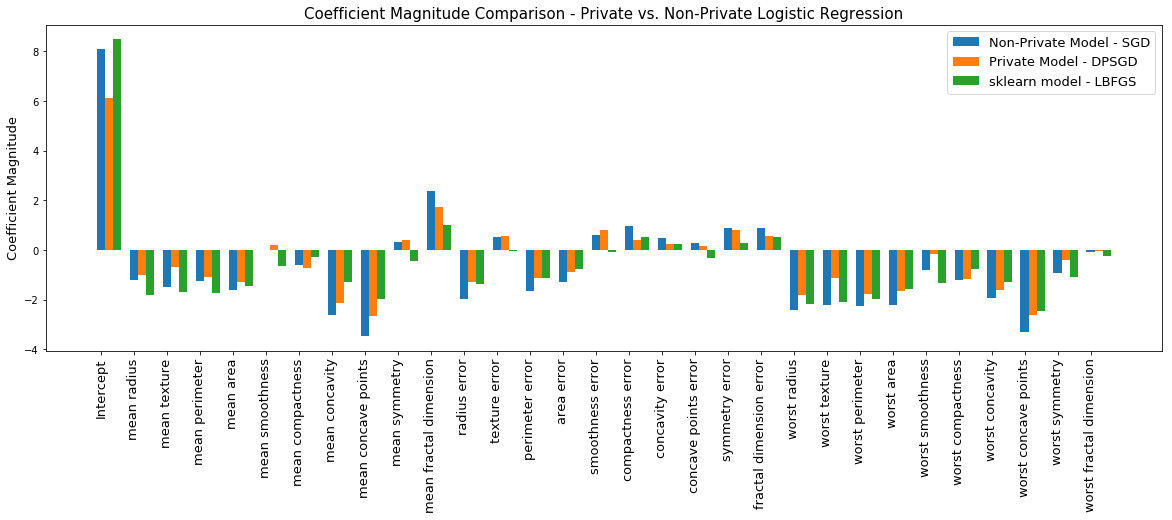

In [12]:
plt.figure(figsize = (20,6))
plt.bar(np.arange(0 , len(model.theta)) * 2, np_model.theta, width = 0.5, label = 'Non-Private Model - SGD')
plt.bar(np.arange(0 , len(model.theta)) * 2 + 0.5 , model.theta, width=0.5, label = 'Private Model - DPSGD')
plt.bar(np.arange(0 , len(model.theta)) * 2 + 1 , list(lr.intercept_) + list((lr.coef_)[0]), width = 0.5, label = 'sklearn model - LBFGS')
plt.legend(fontsize = 13)
plt.xticks(np.arange(0 , len(model.theta)) * 2, ['Intercept'] + list(data.feature_names), rotation = 90, fontsize = 13)
plt.ylabel('Coefficient Magnitude', fontsize = 13)
plt.title('Coefficient Magnitude Comparison - Private vs. Non-Private Logistic Regression', fontsize = 15)
plt.show()

### Experiments with hyperparameters to check expected behaviour

#### Clipping

In [13]:
clipping_param_options = [0.1, 0.5, 1, 1.5, 2, 3, 4]
delta = 1e-6
sigma = 2
run_experiments = False # toggle on to run experiments

In [14]:
if run_experiments == True:

    clipping_expts_models = {}
    clipping_expts_train_preds = {}
    clipping_expts_test_preds = {}
    clip_expt_train_acc = {}
    clip_expt_test_acc = {}
    clip_expt_epsilons = {}
    for C_ in clipping_param_options:

        clipping_expts_models[C_] = DPLogisticRegression(lr=learning_rate, num_iter=n_iter, 
                                                         verbose=False, fit_intercept = True, 
                                                         clipping_param=C_, sigma=sigma,
                                                         delta=delta, tol = tol)

        clipping_expts_models[C_].fit(X_train, y_train, batch_size=batch_size, repeat_data = True, sample_with_replacement = True)
        clipping_expts_train_preds[C_] = clipping_expts_models[C_].predict(X_train, threshold = 0.5)
        clipping_expts_test_preds[C_] = clipping_expts_models[C_].predict(X_test, threshold = 0.5)
        clip_expt_train_acc[C_] = accuracy_score(y_train, clipping_expts_train_preds[C_])
        clip_expt_test_acc[C_] = accuracy_score(y_test, clipping_expts_test_preds[C_])    
        clip_expt_epsilons[C_] = clipping_expts_models[C_].epsilon
        

    # save experiment results
    write = [clipping_expts_models, clipping_expts_train_preds, clipping_expts_test_preds, clip_expt_train_acc, clip_expt_test_acc,clip_expt_epsilons]
    with open('../model_results/breast_cancer_expts_clipping.txt', mode = 'wb') as res:
        pickle.dump(write, res)
        
else:
    # load experiment results
    with open('../model_results/breast_cancer_expts_clipping.txt', mode = 'rb') as chk:
        check = pickle.load(chk)
    clipping_expts_models, clipping_expts_train_preds, clipping_expts_test_preds, clip_expt_train_acc, clip_expt_test_acc,clip_expt_epsilons = check

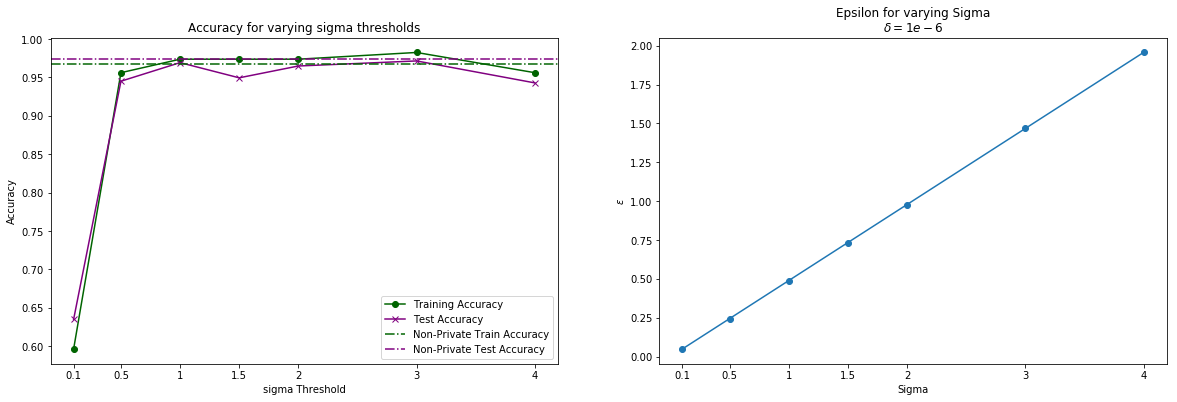

In [15]:
plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
plt.plot(clipping_param_options, list(clip_expt_test_acc.values()), marker = 'o' ,label = 'Training Accuracy', c = 'darkgreen')
plt.plot(clipping_param_options, list(clip_expt_train_acc.values()), marker = 'x', label = 'Test Accuracy', c = 'purple')
plt.axhline(np_train_acc, label = 'Non-Private Train Accuracy', ls = '-.', c = 'darkgreen')
plt.axhline(np_test_acc, label = 'Non-Private Test Accuracy', ls = '-.', c = 'purple')
plt.xticks(clipping_param_options, clipping_param_options); plt.legend()
plt.title('Accuracy for varying sigma thresholds'); plt.xlabel('sigma Threshold'); plt.ylabel('Accuracy')
plt.subplot(1,2,2)
plt.plot(clipping_param_options, list(clip_expt_epsilons.values()), marker = 'o')
plt.xticks(clipping_param_options, clipping_param_options);
plt.title('Epsilon for varying Sigma\n$\delta = 1e-6$'); plt.xlabel('Sigma'); plt.ylabel('$\epsilon$')
plt.show()

#### Probability of failure, delta

In [16]:
delta_param_options = [1e-2, 1/X.shape[0], 1e-3, 1e-4, 1e-5, (1/X.shape[0])**2]

In [17]:
def max_eps(delta, clipping_param = clipping_param, sigma = sigma, 
            batch_size = batch_size, X_train = X_train):
    return (clipping_param/sigma)*(batch_size/X_train.shape[0])*np.sqrt(X_train.shape[0]//batch_size * np.log(1/delta))

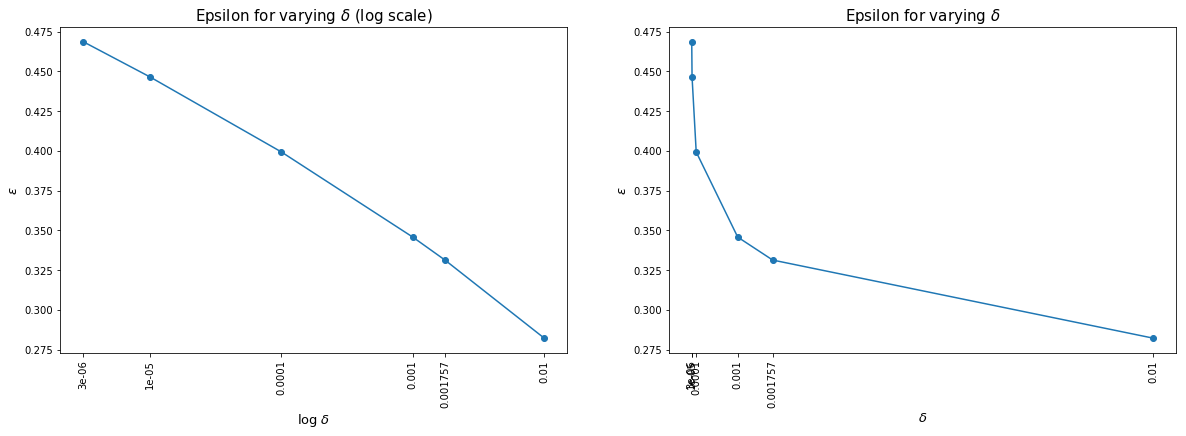

In [18]:
plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
plt.plot(np.log(delta_param_options), [max_eps(x) for x in delta_param_options], marker = 'o')
plt.xticks(np.log(delta_param_options), [round(x,6) for x in delta_param_options], rotation = 90);
plt.title('Epsilon for varying $\delta$ (log scale)', fontsize = 15); 
plt.xlabel('log $\delta$', fontsize = 13); plt.ylabel('$\epsilon$', fontsize = 13)
plt.subplot(1,2,2)
plt.plot((delta_param_options), [max_eps(x) for x in delta_param_options], marker = 'o')
plt.xticks((delta_param_options), [round(x,6) for x in delta_param_options], rotation = 90);
plt.title('Epsilon for varying $\delta$', fontsize = 15); 
plt.xlabel('$\delta$', fontsize = 13); plt.ylabel('$\epsilon$', fontsize = 13)
plt.show()

#### Sigma, variance of noise added

In [19]:
sigma_param_options = [0.5,1,2,3,4,5]
delta = 1e-6
clipping_param = 0.7
run_experiments = False # toggle on to run your own experiments

In [20]:
if run_experiments == True:
    sigma_expts_models = {}
    sigma_expts_train_preds = {}
    sigma_expts_test_preds = {}
    sigma_expt_train_acc = {}
    sigma_expt_test_acc = {}
    sigma_expt_epsilons = {}
    for sig_ in sigma_param_options:

        sigma_expts_models[sig_] = DPLogisticRegression(lr=learning_rate, num_iter=n_iter, verbose=False,
                                                      fit_intercept = True, clipping_param=clipping_param, 
                                                      sigma=sig_, delta=delta, tol = tol)

        sigma_expts_models[sig_].fit(X_train, y_train, batch_size=batch_size, repeat_data = True, sample_with_replacement = True)
        sigma_expts_train_preds[sig_] = sigma_expts_models[sig_].predict(X_train, threshold = 0.5)
        sigma_expts_test_preds[sig_] = sigma_expts_models[sig_].predict(X_test, threshold = 0.5)
        sigma_expt_train_acc[sig_] = accuracy_score(y_train, sigma_expts_train_preds[sig_])
        sigma_expt_test_acc[sig_] = accuracy_score(y_test, sigma_expts_test_preds[sig_])    
        sigma_expt_epsilons[sig_] = sigma_expts_models[sig_].epsilon
        
        
    # save experiment results
    write = [sigma_expts_models,sigma_expts_train_preds,sigma_expts_test_preds,sigma_expt_train_acc,sigma_expt_test_acc,sigma_expt_epsilons,]
    with open('../model_results/breast_cancer_expts_noise.txt', mode = 'wb') as res:
        pickle.dump(write, res)
        
else:
    # load experiment results
    with open('../model_results/breast_cancer_expts_noise.txt', mode = 'rb') as chk:
        check = pickle.load(chk)
    sigma_expts_models,sigma_expts_train_preds,sigma_expts_test_preds,sigma_expt_train_acc,sigma_expt_test_acc,sigma_expt_epsilons = check

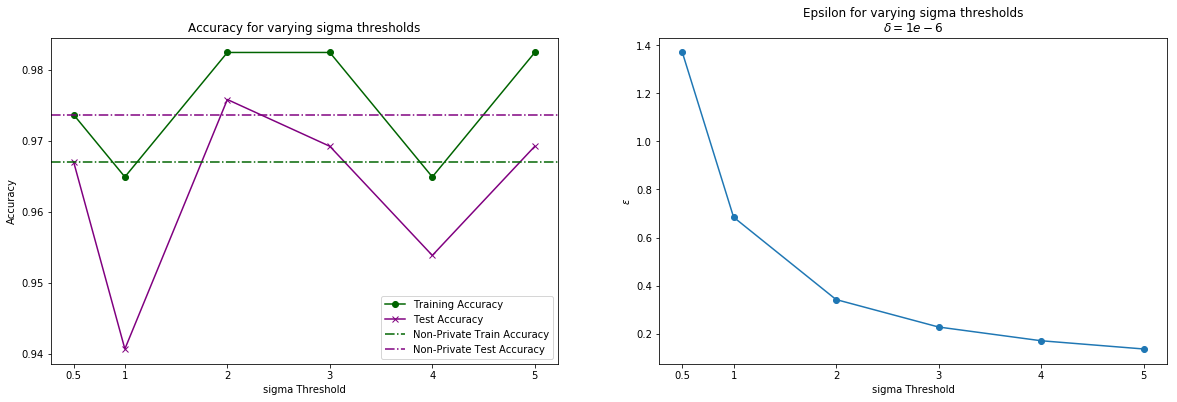

 12%|█▏        | 5888/50000 [00:30<01:05, 670.97it/s]

In [21]:
plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
plt.plot(sigma_param_options, list(sigma_expt_test_acc.values()), marker = 'o' ,label = 'Training Accuracy', c = 'darkgreen')
plt.plot(sigma_param_options, list(sigma_expt_train_acc.values()), marker = 'x', label = 'Test Accuracy', c = 'purple')
plt.axhline(np_train_acc, label = 'Non-Private Train Accuracy', ls = '-.', c = 'darkgreen')
plt.axhline(np_test_acc, label = 'Non-Private Test Accuracy', ls = '-.', c = 'purple')
plt.xticks(sigma_param_options, sigma_param_options); plt.legend()
plt.title('Accuracy for varying sigma thresholds'); plt.xlabel('sigma Threshold'); plt.ylabel('Accuracy')
plt.subplot(1,2,2)
plt.plot(sigma_param_options, list(sigma_expt_epsilons.values()), marker = 'o')
plt.xticks(sigma_param_options, sigma_param_options);
plt.title('Epsilon for varying sigma thresholds\n$\delta = 1e-6$'); plt.xlabel('sigma Threshold'); plt.ylabel('$\epsilon$')
plt.show()